### 背景
自然语言处理常用的方法之一是循环神经网络（RNN）。因此，我们将从 character RNN 入手（预测句子中下一个字符的出现），进一步探讨 RNN 的工作原理，并尝试生成一些原始文本。在此过程中，我们会学习如何在长序列上构建 TensorFlow Dataset。

在本案例中，我们将从安装环境开始，到下载数据集，然后处理划分数据集，搭建RNN模型，然后训练模型，最后进行预测。学会使用无状态 RNN，来实现在每次迭代中学习文本的随机部分。

我们将从一个简单而有趣的模型开始，它能够生成莎士比亚风格的文本。

莎士比亚文本数据集是自然语言处理（NLP）领域常用的数据集之一，它通常包含了莎士比亚的戏剧、诗歌等文本的数字化形式，适用于文本生成、情感分析、机器翻译以及语言模型等多种NLP任务的训练和测试。

莎士比亚文本数据集通常包含以下内容：

戏剧文本：包括莎士比亚的经典戏剧作品，如《哈姆雷特》、《麦克白》、《奥赛罗》等。这些戏剧文本是进行文本生成、情感分析、角色关系分析等NLP任务的理想素材。
诗歌文本：莎士比亚的诗歌作品也是数据集的重要组成部分，这些诗歌通常用于诗歌生成、韵律分析等任务。

下面是一段简短的、由Char-RNN模型（在莎士比亚全部著作上训练而成）生成的文本：


In [43]:
PANDARUS:
Alas, I think he shall be come approached and the day
When little srain would be attain’d into being never fed,
And who is but a chain and subjects of his death,
I should not sleep.

SyntaxError: invalid character '’' (U+2019) (3054785394.py, line 3)

### 使用Character RNN生成莎士比亚风格的文本

首先导入必须的依赖包，使用清华镜像源


In [44]:
!pip install tensorflow -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install numpy -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install dataset -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [45]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import dataset
import os 

首先，使用Keras的get_file()函数，从 Andrej Karpathy 的 Char-RNN 项目，下载所有莎士比亚的作品：
数据集我们可以通过keras直接从这个网址下载：https://homl.info/shakespeare

In [46]:
# 1. 数据准备（截断数据集）
shakespeare_url = "https://homl.info/shakespeare"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()[:10000]  # 只取前10000个字符作为演示

print(f"Text length: {len(shakespeare_text)} characters")

Text length: 10000 characters


数据集的内容如下

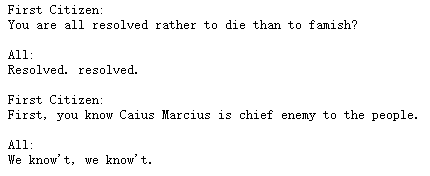

然后，将每个角色编码为一个整数。方法之一是创建一个自定义预处理层，就像之前在第13章做的那样。但在这里，使用Keras的Tokenizer会更加简单。首先，将一个将tokenizer拟合到文本：tokenizer能从文本中发现所有的角色，并将所有角色映射到不同的角色ID，映射从1开始（注意不是从0开始，0是用来做遮挡的，后面会看到）：

In [47]:
# 2. 字符级tokenizer
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts([shakespeare_text])

设置char_level=True，以得到角色级别的编码，而不是默认的单词级别的编码。这个tokenizer默认将所有文本转换成了小写（如果不想这样，可以设置lower=False）。现在tokenizer可以将一整句（或句子列表）编码为角色ID列表，这可以告诉我们文本中有多少个独立的角色，以及总角色数：

In [48]:
# 测试tokenizer
print("Tokenized 'First':", tokenizer.texts_to_sequences(["First"]))
print("Detokenized [20, 5, 10, 6, 3]:", tokenizer.sequences_to_texts([[20, 5, 10, 6, 3]]))

max_id = len(tokenizer.word_index)  # 不同字符的数量
dataset_size = len(shakespeare_text)  
print(f"Unique characters: {max_id}")
print(f"Dataset size: {dataset_size}")

Tokenized 'First': [[20, 5, 10, 6, 3]]
Detokenized [20, 5, 10, 6, 3]: ['f i r s t']
Unique characters: 36
Dataset size: 10000


现在对完整文本做编码，将每个角色都用ID来表示（减1使ID从0到38，而不是1到39）：

In [49]:
encoded = np.array(tokenizer.texts_to_sequences([shakespeare_text])[0]) - 1

继续之前，需要将数据集分成训练集、验证集和测试集。不能大论角色，该怎么处理这种序列式的数据集呢？

在处理莎士比亚风格文本时，我们首先将整个文本数据集按照 90%:5%:5% 的比例切分为训练集、验证集和测试集，以确保模型的泛化能力，并避免数据重叠带来的信息泄露。

接下来，我们使用 tf.data.Dataset 来构建数据流水线，以便高效地加载和处理文本数据。具体而言，我们会将文本转换为字符序列，并利用滑动窗口方法创建输入序列，每个输入序列的目标是预测下一个字符。这种方法能够帮助 RNN 学习字符之间的联系，并生成风格一致的文本。

首先，我们将文本转为字符索引，并使用 tf.data.Dataset.from_tensor_slices 创建一个数据集，其中每个元素是一个字符索引。然后，我们使用 batch 方法将这些字符分割成固定长度的序列，每个序列对应模型的输入，同时，我们会创建一个目标序列，它是输入序列向右偏移一个字符的位置。

例如，假设我们有一个文本片段 "To be or not to be", 我们可以将其映射为字符索引 [19, 14, 0, 1, 4, 0, 17, 14, 19, 0, 19, 14, 0, 1, 4]，然后切分为若干输入-目标对，例如：

输入: ["T", "o", " ", "b", "e", " ", "o", "r", " ", "n", "o", "t", " ", "t", "o"]
目标: ["o", " ", "b", "e", " ", "o", "r", " ", "n", "o", "t", " ", "t", "o", " "]

这样，模型就可以学习到每个字符的上下文，并预测下一个字符。

接下来，我们会调整批量大小，并利用 shuffle 和 prefetch 操作优化数据加载，以确保训练过程高效且稳定。最终，我们将构建一个 RNN 模型，并让它生成莎士比亚风格的文本。

In [50]:
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
print("Train size:", train_size)

Train size: 9000


#### 将序列数据集切分成多个窗口
现在训练集包含一个单独的长序列，超过100万的任务，所以不能直接在这个训练集上训练神经网络：现在的RNN等同于一个有100万层的深度网络，只有一个超长的单实例来训练。所以，得使用数据集的window()方法，将这个长序列转化为许多小窗口文本。每个实例都是完整文本的相对短的子字符串，RNN只在这些子字符串上展开。这被称为截断沿时间反向传播。调用window()方法创建一个短文本窗口的数据集

In [51]:
n_steps = 100 #用短输入序列训练RNN更为简单，但肯定的是RNN学不到任何长度超过n_steps的规律，所以n_steps不要太短。
window_length = n_steps + 1 # target = input 向前移动1个角色
dataset = dataset.window(window_length, shift=1, drop_remainder=True)

默认情况下，window() 方法创建的窗口是互不重叠的，但为了最大化训练数据的利用率，我们将 shift 设为 1，使得窗口之间存在重叠。例如，第一个窗口包含字符 0 到 100，第二个窗口包含字符 1 到 101，依此类推。为了确保所有窗口的长度始终保持在 101 个字符，而不会因为数据长度不足而导致填充问题，我们设置 drop_remainder=True，否则最后的 100 个窗口会分别包含 100、99、98 …… 直到 1 个字符，导致不一致的输入长度。

window() 方法生成的是一个窗口数据集，其中每个窗口本身也是一个数据集。这意味着生成的是一个嵌套数据集，类似于嵌套列表的结构。当需要对每个窗口执行操作（例如打乱数据或创建批次）时，这种嵌套结构是非常有用的。然而，神经网络模型的输入需要的是张量，而不是数据集，因此不能直接使用嵌套数据集进行训练。

为了解决这个问题，我们需要使用 flat_map() 方法，它可以将嵌套数据集转换为扁平化的数据集。例如，假设 {1, 2, 3} 代表一个包含张量 1、2、3 的序列，而嵌套数据集 {{1, 2}, {3, 4, 5, 6}} 在打平后会变成 {1, 2, 3, 4, 5, 6}。此外，flat_map() 还可以接收一个函数作为参数，以便对每个嵌套数据集进行处理。例如，传递 lambda ds: ds.batch(2) 给 flat_map()，会将 {{1, 2}, {3, 4, 5, 6}} 转换为 [{1, 2}, {3, 4}, {5, 6}]，即一个张量大小为 2 的数据集。

掌握了这些概念后，我们就可以使用 flat_map() 方法来打平数据集，使其变成适合神经网络训练的格式。

In [52]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

我们在每个窗口上调用了batch(window_length)：因为所有窗口都是这个长度，对于每个窗口，都能得到一个独立的张量。现在的数据集包含连续的窗口，每个有101个角色。因为梯度下降在训练集中的实例独立同分布时的效果最好，需要打散这些窗口。然后我们可以对窗口做批次，分割输入（前100个角色）和目标（最后一个角色）：

In [53]:
# 5. 批处理和预处理
batch_size = 32
dataset = dataset.shuffle(1000).batch(batch_size)  # 减少shuffle buffer大小
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

图16-1 总结了数据集准备步骤（窗口长度是11，不是101，批次大小是3，不是32）。

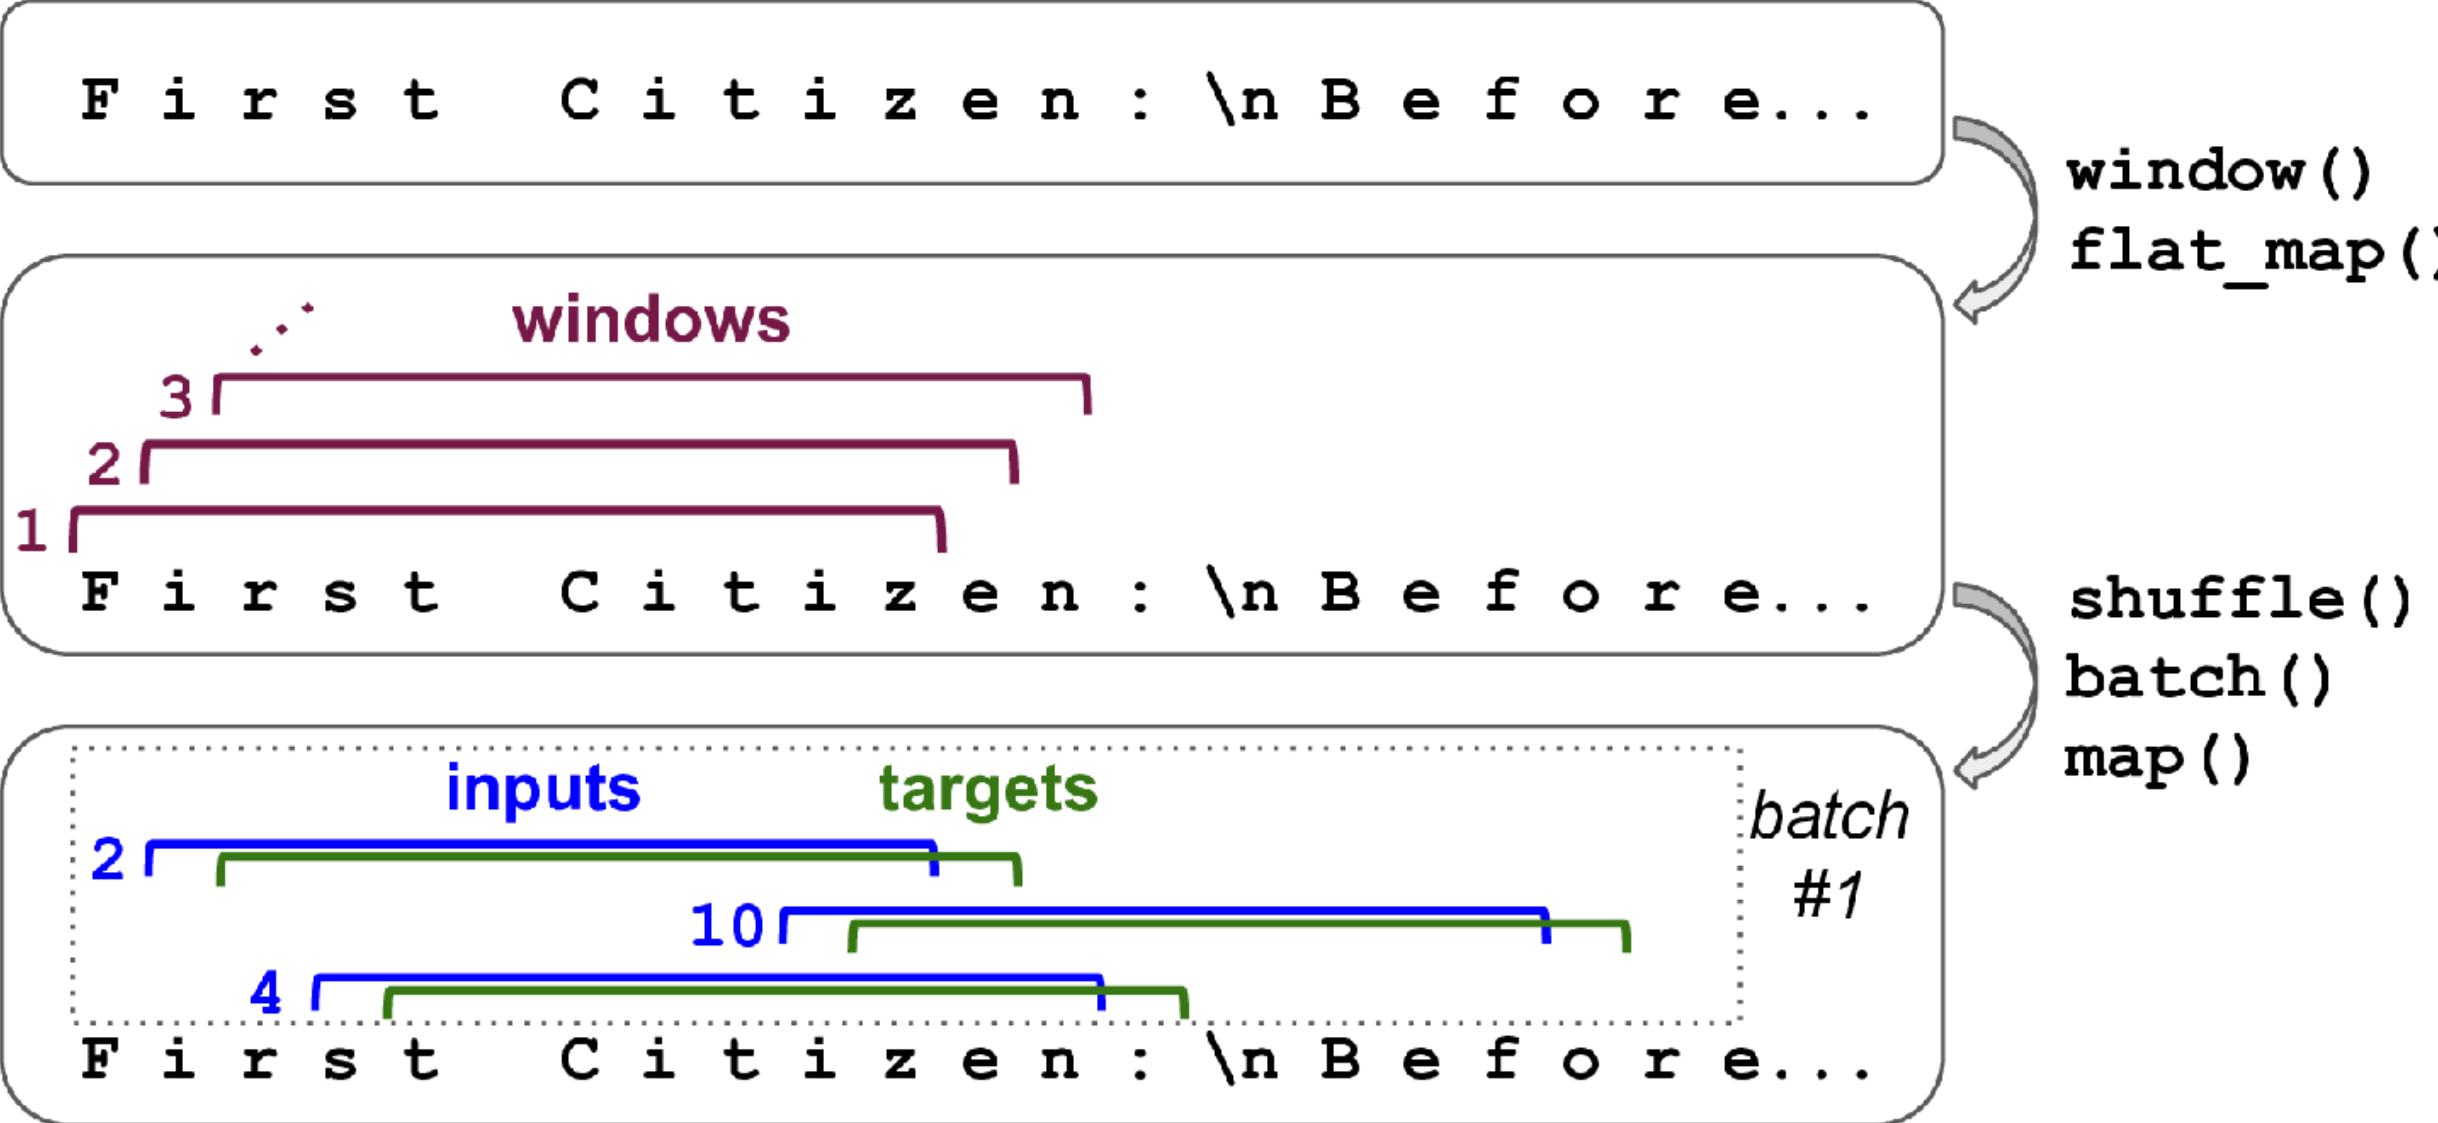

类型输入特征通常都要编码，一般是独热编码或嵌入。这里，使用独热编码，因为独立角色不多（只有39）：

In [54]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)# 预提取

至此，准备数据集的过程已经完成了。下面开始搭建模型。

#### 搭建并训练Char-RNN模型
可以使用一个 RNN 来根据前 100 个字符预测下一个字符，该 RNN 包含两层 GRU，每层有 128 个单元。每个单元对输入（dropout）和隐藏状态（recurrent_dropout）的丢失率均设为 20%，这些超参数在后续训练中可以根据需要进行微调。输出层是一个时间分布的全连接层，包含 39 个单元（max_id），对应文本中的 39 种不同字符，用于计算每个字符在每个时间步出现的概率。为了确保输出概率总和为 1，使用 softmax 作为激活函数。然后，使用 "sparse_categorical_crossentropy" 作为损失函数，并采用 Adam 优化器编译模型。最后，训练模型多个周期，具体训练时间取决于硬件配置，可能需要数小时。

In [55]:
# 构建 RNN 模型
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
model.summary()


history = model.fit(dataset, epochs=1)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_5 (GRU)                     │ (None, None, 128)      │        63,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, None, 128)      │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, None, 36)       │         4,644 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,460 (654.14 KB)

 Trainable params: 167,460 (654.14 KB)

 Non-trainable params: 0 (0.00 B)

279/279 ━━━━━━━━━━━━━━━━━━━━ 189s 659ms/step - loss: 2.8634


#### 使用Char-RNN模型
现在就有了可以预测莎士比亚要写的下一个人物的模型了。输入数据之前，先要像之前那样做预处理，因此写个小函数来做预处理：

In [56]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

现在，用这个模型预测文本：

#### 生成假莎士比亚文本
要让 Char-RNN 生成新文本，可以提供一段初始文本作为输入，让模型预测下一个字符，并将其添加到文本末尾。然后，用扩展后的文本作为新的输入，继续预测下一个字符，依此类推。然而，这种方法在实际应用中可能导致相同的单词不断重复。

为了避免这一问题，可以使用 tf.random.categorical() 函数，根据预测的概率随机选择下一个字符，而不是始终选择最高概率的字符。这样可以生成更加丰富和多样的文本。该函数会依据类别的对数概率（logits）进行随机采样，得到新的字符索引。

为了控制生成文本的多样性，可以引入一个可调参数“温度”（temperature），用于对 logits 进行缩放。较低的温度值会使模型更倾向于选择高概率的字符，而较高的温度值则会使所有字符的选择概率更加接近，从而增加生成文本的随机性。

下面的 next_char() 函数使用这种方法来选择并添加下一个字符到文本中：

In [57]:
# 预测下一个字符
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model.predict(X_new, verbose=0)[0, -1:, :]  
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

然后，可以写一个小函数，重复调用next_char()：

In [58]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

现在就可以生成一些文本了！先尝试下不同的温度数：

In [59]:
print(complete_text("t", temperature=0.2))

print(complete_text("w", temperature=1))

print(complete_text("w", temperature=2))


the the serese the sale the god the rast fire our i
wqto thobst,'thao'd wave lium imact oir thes wir an
wew! khatir,!alebii whio; sevfu
eonvimh,sbel.ekpits


从预测的结果可以看出效果并不是很好，主要的原因有：
1、模型结构比较简单，可以适当增加模型层数。
2、训练数据集：为了缩短实验训练时间，这里总共取了10000条数据集，同学们可以根据实际时间安排来调整训练数据的条数（总共一百万条），从而提高模型的性能表现。

显然，当温度数接近1时，我们的莎士比亚模型效果最好。为了生成更有信服力的文字，可以尝试用更多GRU层、每层更多的神经元、更长的训练时间，添加正则（例如，可以在GRU层中设置recurrent_dropout=0.3）。另外，模型不能学习长度超过n_steps（只有100个角色）的规律。你可以使用更大的窗口，但也会让训练更为困难，甚至LSTM和GRU单元也不能处理长序列。另外，还可以使用有状态RNN。